<h1 style="text-align:center;">Predicting Customer Churn and Customer Segmentation</h1>

# Business Goal

1. Learn to predict the probability of churn (for the upcoming month) for each customer

2. Draw up typical user portraits: Select the most outstanding groups and describe their main features

3. Analyze the factors that impact churn most

4. Draw basic conclusions and develop recommendations on how to improve customer service

### Conclusions and Recommendations

1. Company should place an emphasis on fostering group interaction activities such as group classes. This is especially the case for the customer profile seen earlier(average age 29) since according to fitness reports , studies are showing the effectiveness of group classes in improving retention rate for fitness studios for those in the younger generation (<a href='#reference'  target="_blank">see reference 1 and 2</a>).
2. The second month of a user's lifetime should be of special importance to the company. Of those identified at high risk, offer specialized discounts in addition to reaching out to them. (<a href='#reference'>see reference 3</a>).
3. Create stronger relationships with users who identified as having less chances of churning (coming from partner company or those with > 1 month contract). Offer better discounts or packages for both and continue engagement (<a href='#reference'>see reference 4 and 5</a>).

# Data Sources

Model Fitness provided you with CSV files containing data on churn for a given month and information on the month preceding it.

- 'Churn' — the fact of churn for the month in question

###                     -------------------------User data for the preceding month--------------------------------

- 'gender'
- 'Near_Location' — whether the user lives or works in the neighborhood where the gym is located
- 'Partner' — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
- Promo_friends — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
- 'Phone' — whether the user provided their phone number
- 'Age'
- 'Lifetime' — the time (in months) since the customer first came to the gym

### -----------Data from the log of visits and purchases and data on current membership status----------------

- 'Contract_period' — 1 month, 3 months, 6 months, or 1 year
- 'Month_to_end_contract' — the months remaining until the contract expires
- 'Group_visits' — whether the user takes part in group sessions
- 'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime
- 'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month
- 'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.


# Libraries Used

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, roc_auc_score,\
    precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import itertools
import warnings
warnings.filterwarnings('ignore')

C:\Users\garci\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Initial Exploration

In [2]:
filepath = "https://raw.githubusercontent.com/dannygarcia193/machineLearningProject/master/gym_churn_us.csv"
df =pd.read_csv(filepath)

In [3]:
df.shape

(4000, 14)

Decent sample size. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

All numerical

In [5]:
df.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

In [6]:
#renaming columns 
df.columns = ['gender', 'nearLocation', 'partner', 'promoFriends', 'phone',
       'contractPeriod', 'groupVisits', 'age',
       'avgTotalAdditionalCharges', 'monthToEndContract', 'lifetime',
       'avgWeeklyVisitsLifetime', 'avgWeeklyVisitsCurrentMonth',
       'Churn']

In [7]:
df.head()

,gender,nearLocation,partner,promoFriends,phone,contractPeriod,groupVisits,age,avgTotalAdditionalCharges,monthToEndContract,lifetime,avgWeeklyVisitsLifetime,avgWeeklyVisitsCurrentMonth,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Missing value check.

In [8]:
def missing_values(data):
    """
    Function that takes in a dataframe, iterates over each of its columns and checks for
    common indicators of missing values (ie. negative values).   

    Args:
         data (pandas.DataFrame): Dataframe to be checked

    Returns:
        list (dict): a list containing (if any) a dictionar[y/ies] of key:value pair in the 
        following format - {column's missing value: % of column's missing value} - sorted in descending order
    """
    
    miss = {}
    if len(data.columns) <= 0:
        print('Something went wrong. No columns detected.')
    for i in data.columns:  # iterate through all columns in dataset to search for each defined missing value
        if data[i].isnull().any():
            miss[i] = 'Null values ' + str(
                round(
                    len(data[data[i].isnull() == True]) / len(data) * 100, 2))
        try:
            if len(np.where(data[i] == '')) > 1:
                miss[i] = 'Empty strings ' + str(
                    round(len(data[data[i] == '']) / len(data) * 100, 2))
        except:
            pass
        if np.issubdtype(data[i].dtype,
                         np.number) and len(data[data[i] < 0]) > 1:
            miss[i] = 'Negative values ' + str(
                round(len(data[data[i] < 0]) / len(data) * 100, 2))
        try:
            if len(data[data[i].str.lower.isin(['n/a', 'na', 'an', 'n\a', '?'
                                                ])]) > 1:
                miss[i] = 'other null values present'
        except:
            try:
                if len(data[data[i].isin(['N/A', '?', 'na', 'Na', 'N/a'
                                          ])]) > 1:
                    miss[i] = 'other null values present'
            except:
                print(i)
                continue
    return sorted(miss.items(),
                  key=lambda x: float(miss[x[0]].split(' ')[-1]),
                  reverse=True)

In [9]:
missing_values(df)

[]

No missing values.

In [10]:
df.duplicated().sum()

0

No duplicate values as well. Clean data.

Relatively clean data: no missing values, data types are in correct format and no duplicates. Proceeding to the next stage. 

# Exploratory Data Analysis

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
nearLocation,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promoFriends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contractPeriod,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
groupVisits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avgTotalAdditionalCharges,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
monthToEndContract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Most of the variables are binary and won't need any additional changes. Here is a rough summary: 

- Roughly equally divided by gender
- Users are mostly in their 20s. Ages range from 18 to 41 (average = 29 /  standard dev = 3). 
- Average user stays with the gym for 3 months before churning
- Low visits: Average user visits the gym 2 times per week

Of special note are the near location (84%) and phone (90%) variables of which given their binary value are heavily skewed.  We'll keep this in mind as we might need to drop them--won't provide as much info. and might distort result.


In [12]:
def modifyChart(ax,
                columnLabel,
                labelSize,
                titleSize=False,
                maxs=False,
                xLabel='',
                yLabel=''):
    """
    Function that takes in graph variables for the purpose of customizing 
    their default settings (ie. setting label size)
    """
    if titleSize != False:
        ax.set_title(columnLabel,
                     fontsize=titleSize,
                     fontweight='semibold',
                     pad=10)
    else:
        ax.set_title(columnLabel)

    # spines
    sns.despine()
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('lightgrey')

    # labels
    ax.set_ylabel(yLabel, labelpad=5, fontsize=16)
    ax.set_xlabel(xLabel, labelpad=5, fontsize=16)

    # tick settings
    ax.tick_params(labelsize=labelSize)
    ax.tick_params(axis='both', left=False, bottom=False)
    ax.grid(axis='y', alpha=.4)

    # if a max value is passed
    if maxs:
        midCenterQuarter = (ax.get_yticks()[1] - ax.get_yticks()[0]) / 4  # to ensure that the tick labels don't overlap
        
        ax.set_ylim(0, maxs)  # set the yticks
        # keep all except last  tick - ensure that the ticks don't overlap
        # add the last tick value
        y_ticks = np.append(
            [i for i in ax.get_yticks() if i < (maxs - midCenterQuarter)],[maxs])
        # set the modified y ticks
        ax.set_yticks(y_ticks)

### Plots: Exploring Variables

Plotting binary variables using bar plots.

In [13]:
binary = [col for col in df.columns if df[col].nunique() <= 2]
len(binary)

7

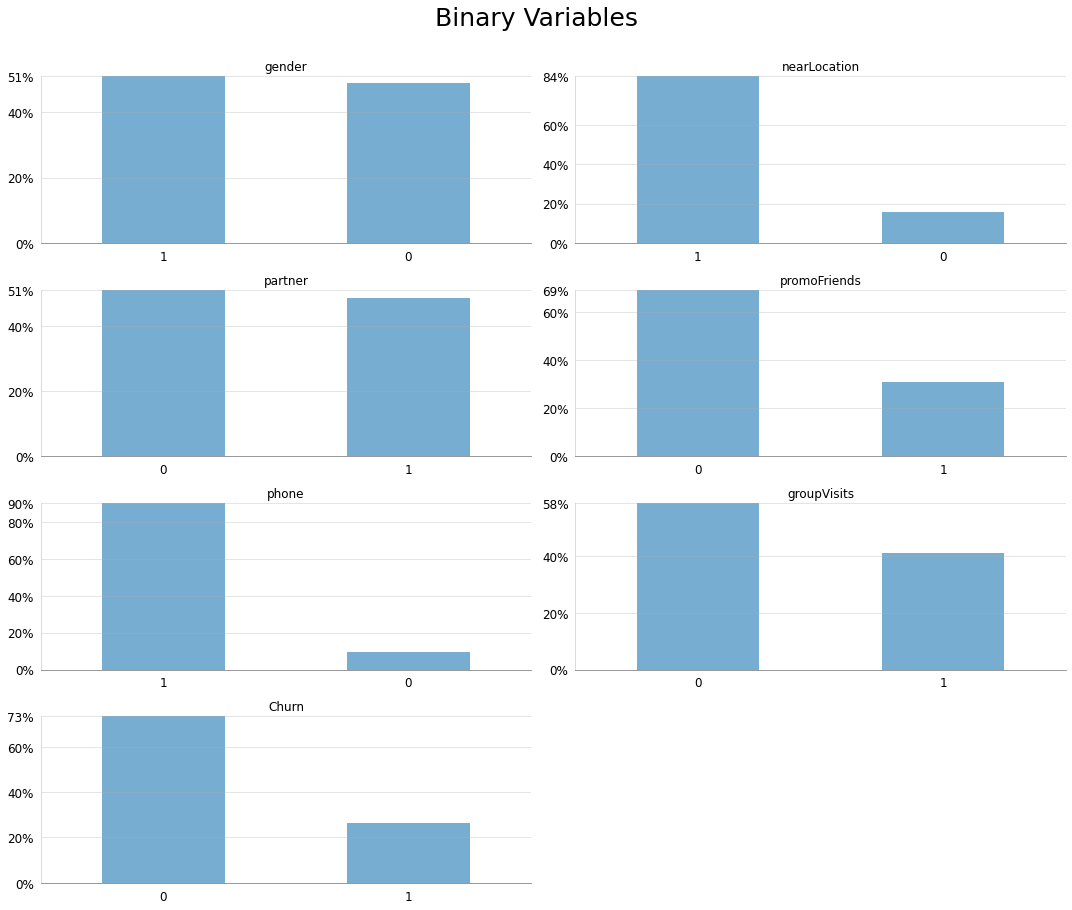

In [14]:
fig, ax = plt.subplots(figsize=(15, 12), ncols=2, nrows=4)

axes = [(row, col) for row in range(4) for col in range(2)]

for col, i in zip(binary, axes):
    #unique values and their counts per column (normalized -> %)
    toChart = df[col].value_counts(normalize=True)
    #bar plot
    toChart.plot.bar(ax=ax[i], rot=0, alpha=.6)
    #calculate maximum value
    maxs = max(df[col].value_counts(normalize=True))
    #modify chart
    modifyChart(ax[i], col, 12, maxs=maxs)
    #set y tick values in % format
    ax[i].set_yticklabels(
        ["{}%".format(int(i * 100)) for i in ax[i].get_yticks()[:]])

#turn off the last chart value as it's empty
plt.suptitle('Binary Variables',fontsize=25,y=1.03)
ax[axes[-1]].axis('off')
plt.tight_layout()

Per the graph: 

- 58% of users take part in group sessions
- 84% live or work near the neighborhood
- Roughly 50% are an employee of a partner company. 
- 1/3 signed up through a "bring a friend" offer

In addition, it looks like the phone variable will not be needed given it's overwhelming 1 relative value as well as it's low relevancy to the target variable. We'll tolerate the location variables as it has > 15% of values placed in the least common unique value and might provided some useful info (it's expected that the closer the gym location, the less the churn rate)..

In [16]:
df.drop(columns='phone',inplace=True)

Visualizing non-binary variables using a distribution plot.

In [17]:
nonBinary = [col for col in df.columns if df[col].nunique() > 2]
len(nonBinary)

7

(0.0, 1.0, 0.0, 1.0)

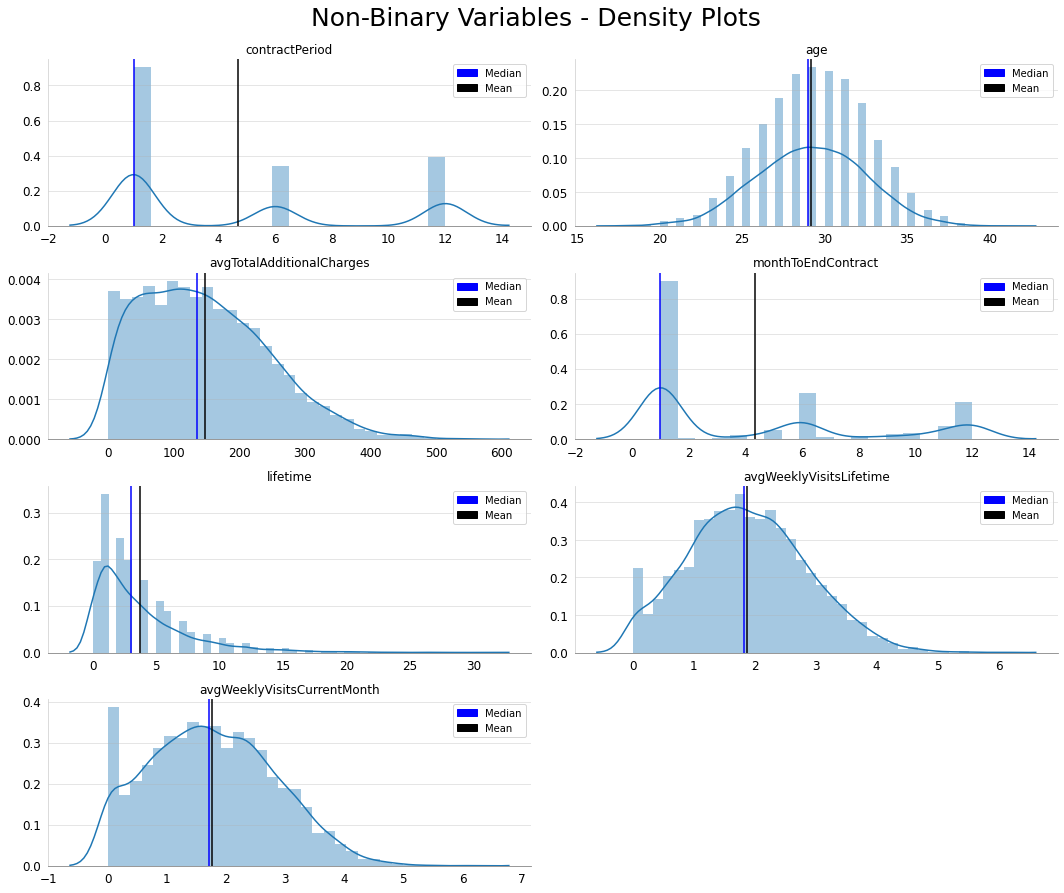

In [19]:
fig, ax = plt.subplots(figsize=(15, 12), ncols=2, nrows=4)

axes = [(row, col) for row in range(4) for col in range(2)]

for col, i in zip(nonBinary, axes):
    sns.distplot(df[col], ax=ax[i])
    modifyChart(ax[i], col, 12)

    ax[i].axvline(df[col].median(), color='blue')
    ax[i].axvline(df[col].mean(), color='black')

    #referring to axes in order to use the pyplot module
    plt.sca(ax[i])
    #custom legend
    azure_patch = mpatches.Patch(color='blue', label='Median')
    orange_patch = mpatches.Patch(color='black', label='Mean')
    plt.legend(handles=[azure_patch, orange_patch])
plt.suptitle('Non-Binary Variables - Density Plots',fontsize=25,y=1.03)
plt.tight_layout()
ax[axes[-1]].axis('off')

Here is summary of the graphs: 

- Most users are relatively new: Roughly half of users have 4 months or less with the company with some long time users having stayed as member for 12 to 30 months as indicated in the right tail of the distribution.
- Month to end contract and contract period tell the same story especially considering that:
    - > 85% of users have 1 month contract
- Avg. weekly visits for current month and lifetime seem to have high correlations with each other. This makes sense as most users have 1 month contracts.

### Plots: Features vs. Independent

In [28]:
#columns to plot
len(df.columns)

13

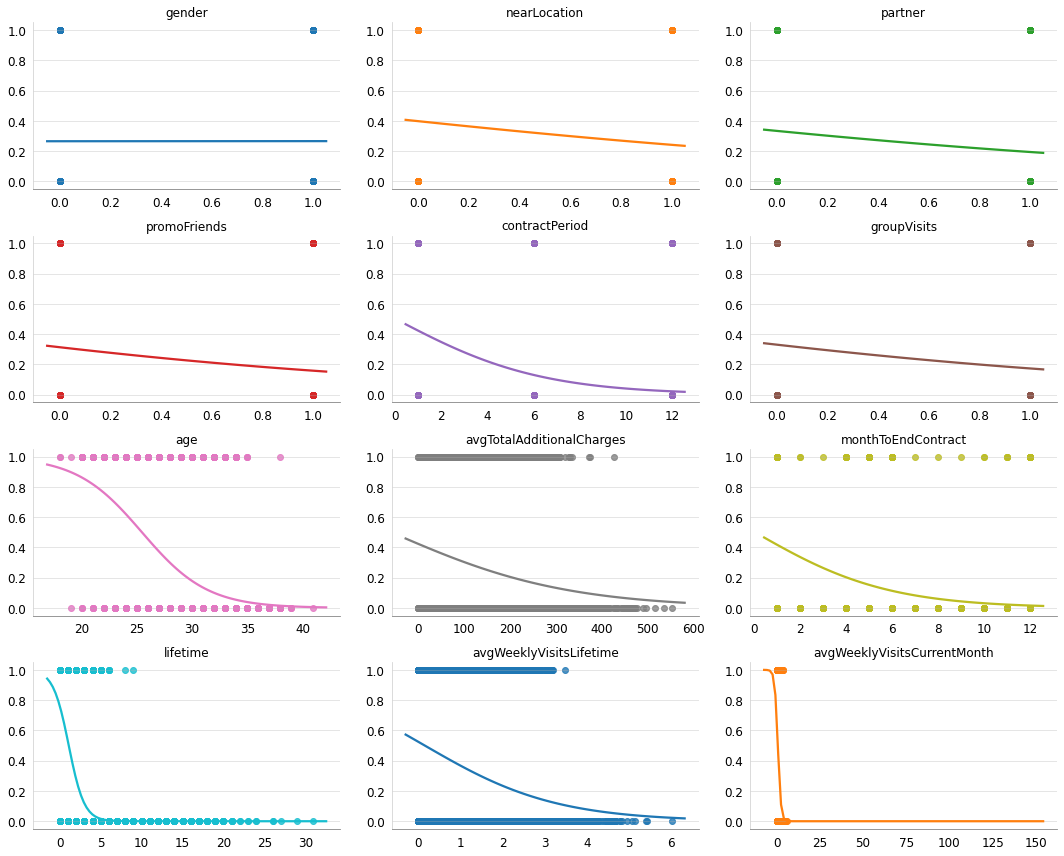

In [20]:
fig, ax = plt.subplots(figsize=(15, 12), ncols=3, nrows=4)

axes = [(row, col) for row in range(4) for col in range(3)]

#dropping target variable column
for col, i in zip(df.drop('Churn', axis=1).columns, axes):
    #skipping this column -> displayed value counts in x axis
    if col == 'avgWeeklyVisitsCurrentMonth': continue

    #logist regression plots
    sns.regplot(df[col], df['Churn'], ci=None, logistic=True, ax=ax[i])
    modifyChart(ax[i], col, 12)

ax[axes[-1]].axis('off')
plt.tight_layout()

#took  of weekly visits current month bc axis was not displaying correctly
Summary:

- Variable such as age, lifetime, weekly visits per month, provide some good indications of having some influence over the predictor variable. 
- Gender yields no relationship (flat). Will be dropping.



### Bar Histograms - Churn vs No Churn Variable comparisons

In [30]:
toChart = df.groupby("Churn").mean()

#how many columns and unique values
print(len(toChart.columns))
print(toChart.index)

12
Int64Index([0, 1], dtype='int64', name='Churn')


In [31]:
toChart = toChart.rename(index={0:'No Churn',1:"Churn"})
toChart

,gender,nearLocation,partner,promoFriends,contractPeriod,groupVisits,age,avgTotalAdditionalCharges,monthToEndContract,lifetime,avgWeeklyVisitsLifetime,avgWeeklyVisitsCurrentMonth
Churn,,,,,,,,,,,,
No Churn,0.510037,0.873086,0.534195,0.353522,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
Churn,0.510839,0.768143,0.355325,0.183789,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


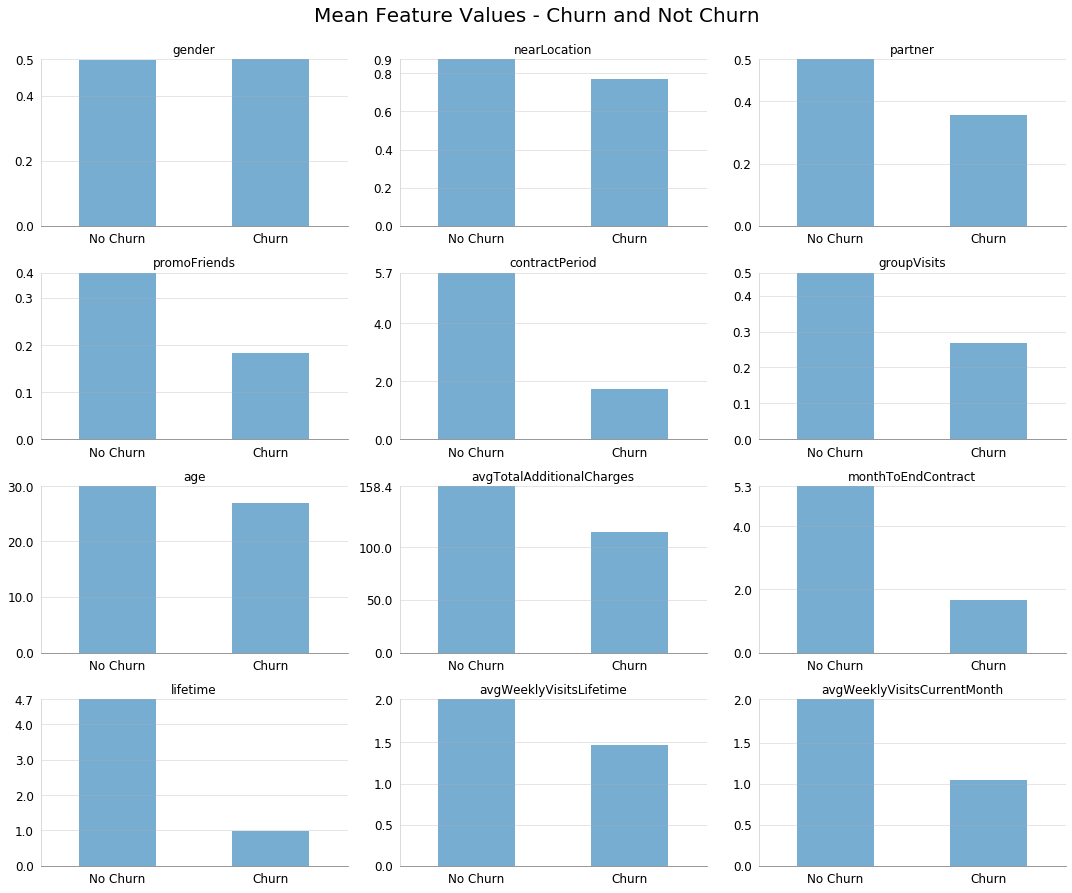

In [32]:
fig, ax = plt.subplots(figsize=(15, 12), ncols=3, nrows=4)
axes = [(row, col) for row in range(4) for col in range(3)]

for col, i in zip(toChart.columns, axes):
    toChart[col].plot.bar(ax=ax[i], rot=0, alpha=.6)

    maxs = max(toChart[col])
    modifyChart(ax[i], col, 12, maxs=maxs)

    ax[i].set_yticklabels(["{:.1f}".format(i) for i in ax[i].get_yticks()])

plt.suptitle("Mean Feature Values - Churn and Not Churn", fontsize=20, y=1.03)
plt.tight_layout()

Here we start seeing some interesting patterns. Relative to no churn, churn users are: 
    - less likely to be an employee from a partner company
    - less likely to enroll through a promotions program
    - less likely to come from group visits
    - spend less in additional charges

So in summary:
    - it seems like social factors, months with company (contract and lifetime), being an employee from a partner company and spending more in-store leads are good indicators for an employee churning or not

We also see some hints of multicollinearity as well in columns such as avgweeklyvisits lifetime and avgweeklyvisitscurrentmonth. In addition to gender not being relevant (will be dropped now).


### Correlation Matrix
Before dropping though, we'll create a correlation matrix to get some further insights.

In [33]:
df.corr().head(3)

,gender,nearLocation,partner,promoFriends,contractPeriod,groupVisits,age,avgTotalAdditionalCharges,monthToEndContract,lifetime,avgWeeklyVisitsLifetime,avgWeeklyVisitsCurrentMonth,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
nearLocation,0.006699,1.000000,-0.005119,0.210964,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986


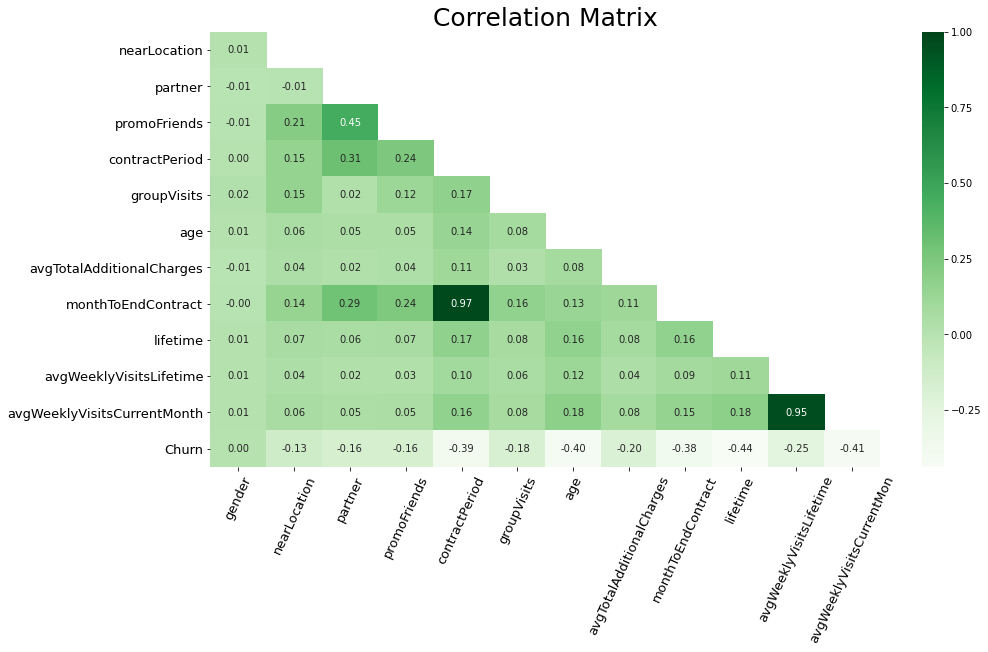

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))

#boolean mask to not diplay duplicatre half
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

sns.heatmap(df.corr(), annot=True, cmap='Greens', mask=mask, fmt='.2f')
#get y limits
bottom, top = ax.get_ylim()
#set y limit and skip last value (empty)-- same for x axis
ax.set_ylim(bottom, 1)
ax.tick_params(labelsize=13)
left, right = ax.get_xlim()
ax.set_xlim(left, right - 1)

#retrieve and show the first 25 characters
ax.set_xticklabels([i.get_text()[:25] for i in ax.get_xticklabels()])
ax.tick_params(axis='x', labelrotation=65)
plt.title("Correlation Matrix",fontsize=25)
plt.show()

So as seen in previous graph, we see an inverse relationship between the feature variables and target variable (ie. the less< weekly visits, the higher chance of churning). 

We also see multicollinearity (> 90%) between weekly visits lifetime and current months as well as contract period and month to end contract variables. As mentioned, this is most likely due to the overwhelming (85%) of users who have one-month contracts. Also notice the 0 Pearson correlation coefficient indicating no relationship between the the target variable--it's safe to drop.



In [23]:
df.drop(columns = ['monthToEndContract','avgWeeklyVisitsLifetime','gender'],inplace=True)
df.head()

,nearLocation,partner,promoFriends,contractPeriod,groupVisits,age,avgTotalAdditionalCharges,lifetime,avgWeeklyVisitsCurrentMonth,Churn
0,1,1,1,6,1,29,14.227470,3,0.000000,0
1,1,0,0,12,1,31,113.202938,7,1.910244,0
2,1,1,0,1,0,28,129.448479,2,1.736502,0
3,1,1,1,12,1,33,62.669863,2,3.357215,0
4,1,1,1,1,0,26,198.362265,3,1.120078,0


# Churn Prediction

Considering model. Standardization is not needed here.

In [24]:
# divide the data into features (the X matrix) and a target variable (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0)

In [25]:
# define the model's algorithm
lr_model = LogisticRegression(random_state=0)

# training model
lr_model.fit(X_train, y_train)
# binary prediction
lr_predictions = lr_model.predict(X_test)
# using the trained model to make forecasts
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

In [26]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

 Random state set to 0. For the remaining parameters of the tree (its depth max_depth, the size of the feature subset max_features, and the minimum number of objects per node min_samples_leaf), we left the default values unchanged.

In [27]:
# defining the new model's algorithm based on the random forest algorithm
rf_model = RandomForestClassifier(random_state=0, n_estimators=100)
#fitting the model  with training datra
rf_model.fit(X_train, y_train)

# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test)  #binary
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]  #ratio

In [28]:
# define the function that will output metrics
def print_all_metrics(y_true, y_pred, y_proba, title='Classification metrics'):
    """ 
    This function prints out all relevant metrics
    """
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [29]:
# set the threshold  (due to unbalanced set)
threshold = .4

# calculate prediction on the basis of probabilities and the ratio between classes
custom_predictions = [0 if i < threshold else 1 for i in lr_probabilities]

In [30]:
# print all studied metrics for the resulting prediction
print_all_metrics(y_test,
                  lr_predictions,
                  lr_probabilities,
                  title='Metrics for logistic regression (50% Ratio):')
print()
print_all_metrics(y_test,
                  custom_predictions,
                  lr_predictions,
                  title='Metrics for logistic regression (40% Ratio):')

Metrics for logistic regression (50% Ratio):
	Accuracy: 0.90
	Precision: 0.82
	Recall: 0.81
	F1: 0.81
	ROC_AUC: 0.96

Metrics for logistic regression (40% Ratio):
	Accuracy: 0.90
	Precision: 0.77
	Recall: 0.87
	F1: 0.82
	ROC_AUC: 0.87


In [31]:
print_all_metrics(y_test,
                  rf_predictions,
                  rf_probabilities,
                  title='Metrics for random forest:')

Metrics for random forest:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.80
	F1: 0.81
	ROC_AUC: 0.95


According to the a <a href="https://www.ihrsa.org/improve-your-club/15-surprising-facts-about-health-club-member-retention/">report</a> published by the International Health, Racquet & Sportsclub Association (IHRSA) in 2017, for a given health club, keeping an existing customer is 5 times less expensive that it is to attract a new customer. Given this, the metrics of special interest would have to be in focusing on catching potential churn members and adding incentives to keep them as members. In addition, those who are more likely to churn will be given the extra attention rather than those with relatively lower risks of churning. As such, reducing the false positive rates will be the metric in choosing the best fit model for the task at hand--focusing on intervention for high-risk churners. 

#### Per the metrics, the most fitting model will therefore be the Logistic Regression one at it's standard 50% threshold. 



In [32]:
def plot_confusion_matrix(cm,
                          labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(cm,
                cmap=cmap,
                annot=True,
                square=True,
                fmt='.0f',
                annot_kws={"fontsize": 15})

    #title and tick labels
    plt.title(title, pad=20, fontsize=20)
    ax.set_yticklabels(labels, fontsize=13)
    ax.set_xticklabels(labels, fontsize=13)

    #label chart settings
    plt.ylabel('Label', labelpad=15, fontsize=17)
    plt.xlabel('Predicted label', labelpad=15, fontsize=17)
    plt.show()

### Final Model (for first stage)

In [33]:
# defining the new model's algorithm based on the logistic regression
final_model = LogisticRegression(random_state=0)
final_model.fit(X_train, y_train)

# use the trained model to make predictions
final_predictions = final_model.predict(X_test)
final_probabilities = final_model.predict_proba(X_test)[:, 1]

In [34]:
print_all_metrics(y_test,
                  final_predictions,
                  final_probabilities,
                  title='Metrics for random forest:')

Metrics for random forest:
	Accuracy: 0.90
	Precision: 0.82
	Recall: 0.81
	F1: 0.81
	ROC_AUC: 0.96


Confusion matrix, without normalization


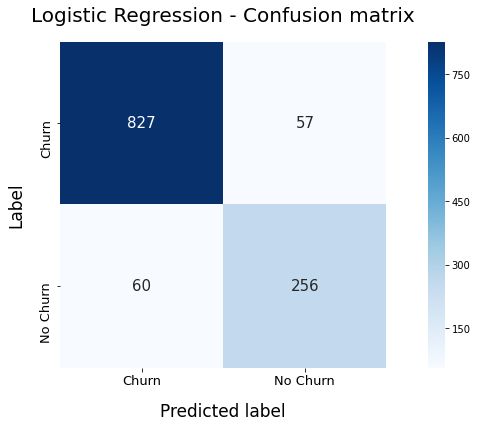

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, lr_predictions)

plot_confusion_matrix(cnf_matrix,
                      normalize=False,
                      labels=['Churn', 'No Churn'],
                      title='Logistic Regression - Confusion matrix')

### Feature Importance 

[9.44487782]


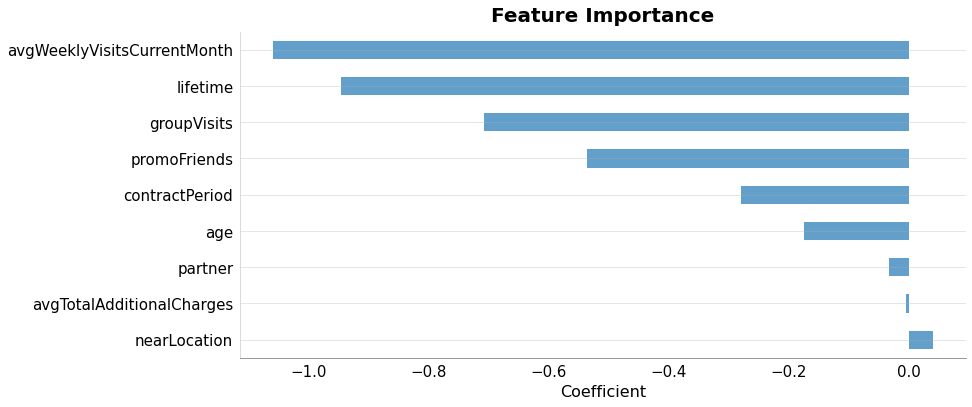

In [38]:
# print y intercept
print(final_model.intercept_)
# creating a DataFrame with feature names and importance
fi_df = pd.DataFrame(data={
    'feature': X.columns,
    'importance': final_model.coef_[0]
}).sort_values('importance', ascending=False)

# horizontal bar chart
ax = fi_df.plot.barh(figsize=(13, 6), alpha=.7, legend=False)
ax.set_yticklabels([i for i in fi_df['feature'].values])
modifyChart(ax, 'Feature Importance', 15, titleSize=20)
plt.xlabel("Coefficient")
plt.show()

Less chance of churning: 
    - avg weekly visits per current month
    - lifetime  (longer time with company)
    - group visits
    - promo friends
    - contract period
   

# User Clusters

In [39]:
#standardization of data before passing it to the algorithm
sc = StandardScaler()
X_sc = sc.fit_transform(X)
#matrix of distances based on the standardized feature matrix
linked = linkage(X_sc, method='ward')

Should note that this takes roughly 5 minutes..

In [ ]:
plt.figure(figsize=(15, 10))

#dendogram -> hierarchical clustering treemap
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for Customers')
plt.show()

Using 5 clusters to create the groups via the K-Means algorithm.

In [51]:
km = KMeans(n_clusters=5)  # setting the number of clusters as 5
labels = km.fit_predict(
    X_sc)  # applying the algorithm to the data and forming a cluster vector

# store cluster labels in the field of our dataset
df['customerCluster'] = labels

# print the statistics of the mean feature values per cluster
paired = df.groupby('customerCluster').mean()
paired

,nearLocation,partner,promoFriends,contractPeriod,groupVisits,age,avgTotalAdditionalCharges,lifetime,avgWeeklyVisitsCurrentMonth,Churn
customerCluster,,,,,,,,,,
0,0.954819,0.484940,0.256024,5.668675,0.424699,30.295181,166.315845,12.518072,2.272951,0.000000
1,1.000000,0.153944,0.094148,3.590331,1.000000,29.395674,146.426795,2.830789,1.784477,0.245547
2,1.000000,0.226950,0.060284,2.703901,0.000000,28.606383,140.962531,2.434397,1.582473,0.426418
3,0.996534,0.966205,0.835355,7.975737,0.506932,29.546794,152.826228,3.554593,1.880508,0.123050
4,0.000000,0.490000,0.071667,2.945000,0.228333,28.681667,136.832314,2.783333,1.593088,0.408333


0 an 1 lowest chance of churning as well as 4

In [52]:
# silhouette score for the clustering
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.16


More likely than not, users in clusters have some overlapping features. Plotting mean feature values to get a better view of the clusters.

In [53]:
len(df.columns) 

11

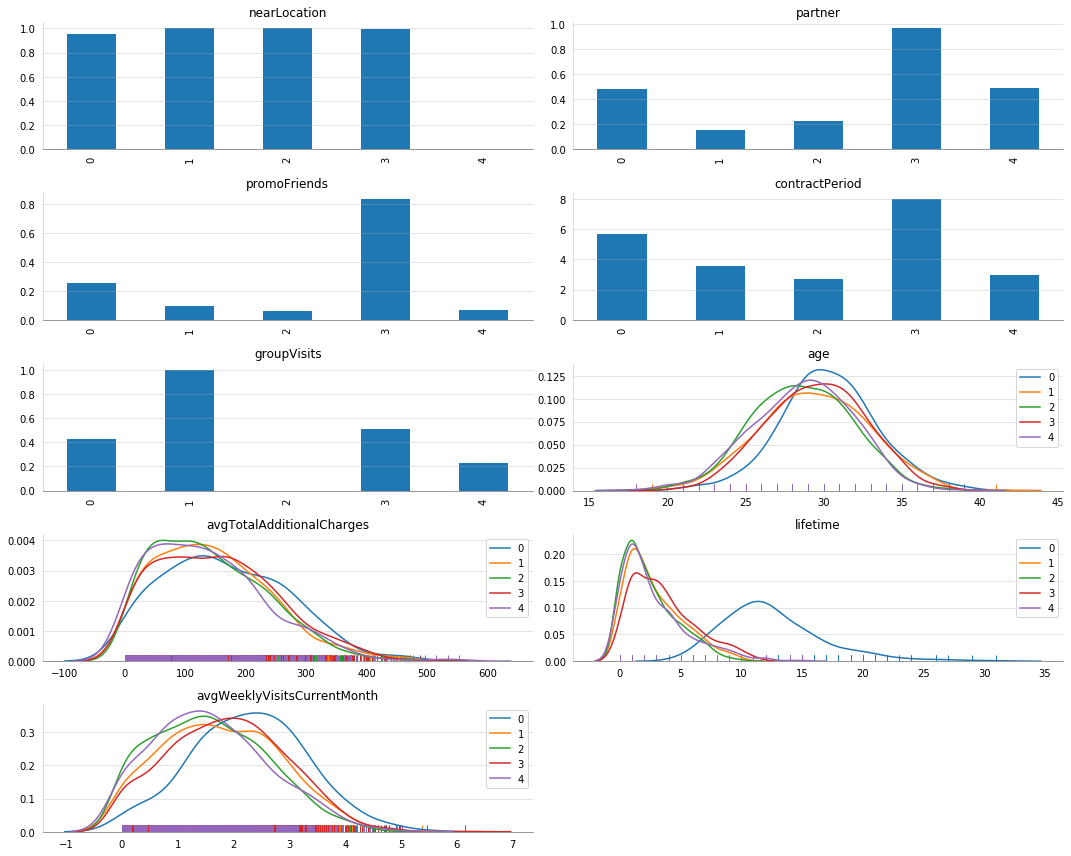

In [54]:
# mean feature values for clusters.
fig, ax = plt.subplots(figsize=(15, 12), ncols=2, nrows=5)
axes = [(row, col) for row in range(5) for col in range(2)]

for col, i in zip(df.drop('Churn', axis=1).columns, axes):
    # groupby feature ignored
    if 'customerCluster' in col:
        continue

    # to check if  one unqie value in grouped columns
    check = list(df.groupby('customerCluster').agg({col: 'nunique'}).values)
    # if so or if unique columns  values are less than 3
    if 1 in check or df[col].nunique() <= 3:
        # than bar plot
        df.groupby('customerCluster').agg({ col: 'mean' }).plot.bar(ax=ax[i], legend=False)
        modifyChart(ax[i], col, 10)
        continue

    # else create a facet grid to display mutliple  distribution plots within one graph
    g = sns.FacetGrid(data=df, hue='customerCluster')
    g.map(sns.distplot, col, hist=False, rug=True, ax=ax[i])

    # chart modifications
    [ax[i].spines[spine].set_visible(False) for spine in ['top', 'right']]
    modifyChart(ax[i], col, 10)
    plt.close()

ax[axes[-1]].axis('off')
plt.tight_layout()

Summary:

- Cluster 3 users are way more likely to come through a partner company as well be referred through a friend promotion. In addition their contracts are on average 8 months.
    - Seems like company partners yields a great opportunity due to social nature of fellow employees going to the gym a indicated by the friend promotion prob. and partner company employees probabilities.
- Users from cluster 1 all took part of a group session.
- Cluster 0 users have the next longest contract at 6 months. In addition, as indicated by their distributions, they are also most likely to take on additional charges, have higher weekly visits, have a much higher lifetime, and are a little older than the other cluster users. 

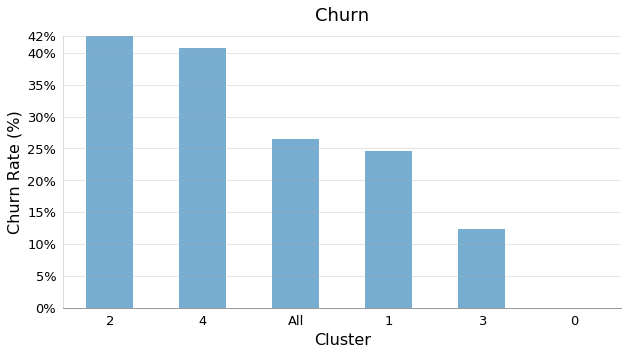

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))
#chart with added series for the purposes of diplaying a bar showing aggregate churn rate
df.groupby('customerCluster').agg({
    'Churn': 'mean'
}).append(pd.Series(df['Churn'].mean(), index=('Churn', ),
                    name='All')).sort_values(
                        'Churn', ascending=False).plot.bar(ax=ax,
                                                           alpha=.6,
                                                           rot=0,
                                                           legend=False)

maxs = max([category.get_height() for category in ax.patches])
modifyChart(ax, col, 13, maxs=maxs, xLabel='Cluster', yLabel='Churn Rate (%)')

ax.set_yticklabels(["{}%".format(int(i * 100)) for i in ax.get_yticks()[:]])
ax.set_title('Churn', fontsize=18, pad=15)
plt.show()

Cluster 2,3, and 3 users are the most likely to churn and should be of interest to the company.

Getting an overview of the mean feature values.

In [56]:
# heatmap across column
paired.sort_values('Churn',
                   ascending=False).transpose().style.background_gradient(
                       cmap='Greens', axis=1)

customerCluster,2,4,1,3,0
nearLocation,1,0,1,0.996534,0.954819
partner,0.22695,0.49,0.153944,0.966205,0.48494
promoFriends,0.0602837,0.0716667,0.0941476,0.835355,0.256024
contractPeriod,2.7039,2.945,3.59033,7.97574,5.66867
groupVisits,0,0.228333,1,0.506932,0.424699
age,28.6064,28.6817,29.3957,29.5468,30.2952
avgTotalAdditionalCharges,140.963,136.832,146.427,152.826,166.316
lifetime,2.4344,2.78333,2.83079,3.55459,12.5181
avgWeeklyVisitsCurrentMonth,1.58247,1.59309,1.78448,1.88051,2.27295
Churn,0.426418,0.408333,0.245547,0.12305,0


Summary:

- Across the board, the following features as previously shown in our model, decrease the chances of churning the higher their values are: 
    - Total charge, employee of a partner company, longer term contract,promotion though friend, and lifetime in months
- Interestingly enough, users coming from clusters with a relatively high churn rate (> 40%) on average last 2 month with the gym. Considering the higher values, for the other clusters, the 2nd month of a cluster will be of interest to the company in terms of customer engagement. 

# Conclusions and Recommendations

Based on the previous findings as well as some external reports, here are some recommendations for improving customer retention and churn:

#### 1. Company should place an emphasis on fostering group interaction activities such as group classes. This is especially the case for the customer profile seen earlier(average age 29) since according to fitness reports , studies are showing the effectiveness of group classes in improving retention rate for fitness studios for those in the younger generation (see 1 and 2).

#### 2. The second month of a user's lifetime should be of special importance to the company. Of those identified at high risk, offer specialized discounts in addition to reaching out to them. (see 3).

#### 3. Create stronger relationships with users who identified as having less chances of churning (coming from partner company or those with > 1 month contract). Offer better discounts or packages for both and continue engagement (see 4 and 5).



-------------------------------------------------------------------------------------------------------------
References:
1. <i><a href="https://www.glofox.com/blog/the-gym-membership-retention-statistics-worth-retaining-in-2019/">Running group classes in your studio delivers a higher rate of retention</a></i>


2. <i><a href="https://www.ihrsa.org/improve-your-club/15-surprising-facts-about-health-club-member-retention/">Social interaction affects renewals. The risk of cancellation was 56% higher among members who just use gym equipment vs. those who exercise in groups. ... Social interaction also affects overall member satisfaction; 70% of club members who had made new friends through their membership self-identified as club "promoters" rather than club "detractors.</a></i>


3. <i><a href="https://www.ihrsa.org/improve-your-club/10-ways-member-engagement-drives-health-club-retention/">IHRSA report found that members at risk of cancelling who received a “successful commitment interaction” were 45% less likely to cancel in the subsequent month than those who didn’t have an interaction.</a></i>


4. <a href="https://media.bain.com/Images/BB_Prescription_cutting_costs.pdf">Report by Bain & Company,an American management consultancy, on the value of building loyal relationship with customers.</a>


5. <i><a href="https://www.precor.com/en-us/resources/one-million-strong-study-retention">Members who joined and committed to 12-month membership agreements (regardless of payment frequency) had a higher rate of retention than members who joined month-to-month without any commitment.</a></i>

<a id='reference'></a>